# A CPU pipeline to process 360 double field-of-view scan using HTTomo 

1. Normalise the data, take the negative log
2. Stripes detection and binary mask creation as the data has got vertical bands with missing data
3. Inpainting of the regions based on the provided mask 
4. Comparing the result of the inpainting with the stripe removal algorithm
5. Finding the center of rotation in the 360 degrees sinogram
6. Converting 360 degres projection data to the conventional 180 degrees one
7. Reconstructing with the Gridrec algorithm
8. Save the result as tiffs

NOTE: The data is the 360 degrees scan acquired on I12 beamline, DLS, UK

In [1]:
import sys
from datetime import datetime
import os
from os import mkdir
import matplotlib.pyplot as plt
import yaml
import pprint

from mpi4py import MPI
import numpy as np
from nvtx import annotate
import multiprocessing
import tomopy

from httomo.common import PipelineTasks
from httomo.data.hdf.loaders import standard_tomo
from httomo.data.hdf._utils.save import intermediate_dataset
from httomo.data.hdf._utils.reslice import reslice

FileNotFoundError: [Errno 2] No such file or directory: 'git'


In [2]:
# load the corresponding YAML configuration ftask ile which can be excecuted through the HTTomo task runner
pipeline = yaml.safe_load(open('../../pipeline_template_examples/DLS_specific/01_sino360_to180covert_inpainting.yaml'))
pp = pprint.PrettyPrinter(indent=1)

# set paths to the data
current_dir = os.getcwd()
main_data_path = "/dls/i12/data/2022/nt32462-1/rawdata/"
#main_data_path = "/media/algol/29B3CEA03D85F0EA/DATA/i12/360scan_large_rings/"
#main_data_path = "/scratch/daniil/data/i12/360_scan_stripes/"
in_file = os.path.join(main_data_path,"112482.nxs")
run_out_dir_main = os.path.join(main_data_path, "output_temp")
run_out_dir = os.path.join(run_out_dir_main, f"{datetime.now().strftime('%d-%m-%Y_%H_%M_%S')}_output")

comm = MPI.COMM_WORLD
if comm.rank == 0:
    if not os.path.exists(run_out_dir_main):
        os.makedirs(run_out_dir_main)    
    mkdir(run_out_dir)    
if comm.size == 1:
    ncore = multiprocessing.cpu_count() # use all available CPU cores if not an MPI run

{'data_path': 'entry1/tomo_entry/data/data',
 'dimension': 1,
 'image_key_path': '/entry1/instrument/image_key/image_key',
 'name': 'tomo',
 'pad': 0,
 'preview': [None, {'start': 1318, 'stop': 1322}, None]}
The full dataset shape is (3751, 2160, 2560)
[0] Pad values are (0, 0).
/dls/i12/data/2022/nt32462-1/rawdata/112482.nxs
entry1/tomo_entry/data/data
100:3701, 1318:1322:, :
[0] Data shape is (3601, 4, 2560) of type uint16


Text(0.5, 1.0, 'Raw sinogram')

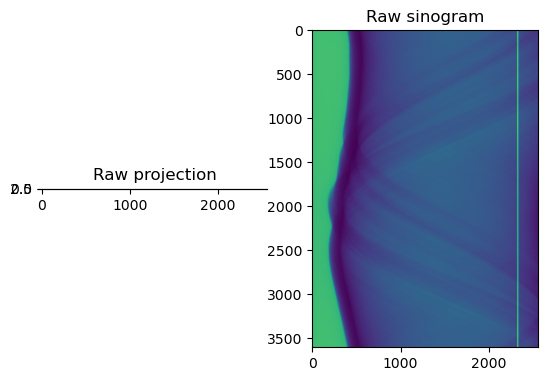

In [3]:
# getting the dictionaries from the YAML template file
standard_tomo_params = pipeline[0]['httomo.data.hdf.loaders']['standard_tomo']
pp.pprint(standard_tomo_params) # print parameters from the YAML template

# Loading the data
data, flats, darks, angles, angles_total, detector_y, detector_x = standard_tomo(standard_tomo_params['name'],
                                                                                 in_file, 
                                                                                 standard_tomo_params['data_path'],
                                                                                 standard_tomo_params['image_key_path'],
                                                                                 standard_tomo_params['dimension'],
                                                                                 standard_tomo_params['preview'],
                                                                                 standard_tomo_params['pad'],
                                                                                 comm)

plt.figure()
plt.subplot(121)
plt.imshow(data[0,:,:])
plt.title('Raw projection')
plt.subplot(122)
plt.imshow(data[:,2,:])
plt.title('Raw sinogram')

Text(0.5, 1.0, 'Normalised magnified sinogram')

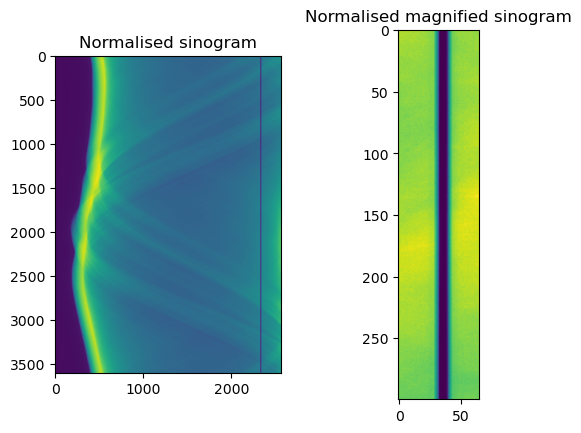

In [4]:
# Normalising the data
from tomopy.prep.normalize import normalize, minus_log
data = normalize(data, flats, darks, ncore=ncore, cutoff=10)
data[data == 0.0] = 1e-09
data = tomopy.minus_log(data, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[:,2,:])
plt.title('Normalised sinogram')
plt.subplot(122)
plt.imshow(data[0:300,2,2295:2360])
plt.title('Normalised magnified sinogram')

{'data_in': 'tomo',
 'data_out': 'stripes_weight',
 'gradient_gap': 2,
 'search_window_dims': '(1,5,1)',
 'vert_window_size': 5}


Text(0.5, 1.0, 'Estimated stripes Weights')

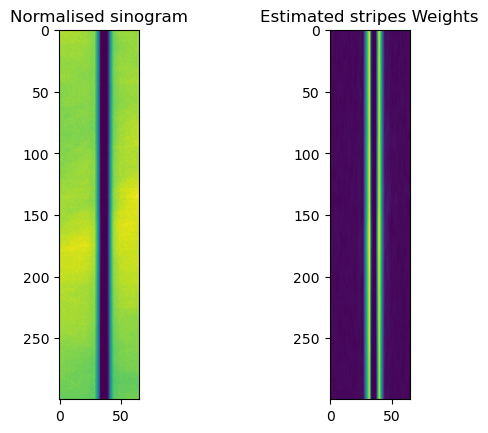

In [5]:
# Running stripes detection module
from httomo.prep.stripe import detect_stripes
from ast import literal_eval

detectstripes_params = pipeline[3]['httomo.prep.stripe']['detect_stripes']
pp.pprint(detectstripes_params) # print parameters from the YAML template

stripes_weight = detect_stripes(data,
                                literal_eval(detectstripes_params['search_window_dims']),
                                detectstripes_params['vert_window_size'],
                                detectstripes_params['gradient_gap'],
                                ncore=ncore)
plt.figure()
plt.subplot(121)
plt.imshow(data[0:300,2,2295:2360])
plt.title('Normalised sinogram')
plt.subplot(122)
plt.imshow(stripes_weight[0:300,2,2295:2360])
plt.title('Estimated stripes Weights')

{'data_in': 'stripes_weight',
 'data_out': 'stripes_mask',
 'mask_dilate': 2,
 'stripe_width_max_perc': 5,
 'threshold_stripes': 0.1}


Text(0.5, 1.0, 'Magnified mask')

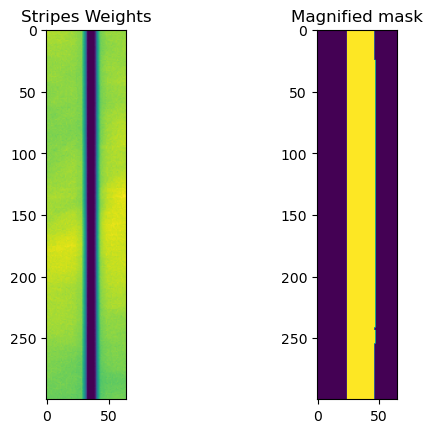

In [6]:
# generate a mask from weights and merge stripes
from httomo.prep.stripe import merge_stripes

mergestripes_params = pipeline[4]['httomo.prep.stripe']['merge_stripes']
pp.pprint(mergestripes_params) # print parameters from the YAML template

stripes_mask = merge_stripes(stripes_weight,
                             stripe_width_max_perc=5,
                             mask_dilate=5,
                             threshold_stripes=0.004,
                             ncore=ncore)
plt.figure()
plt.subplot(121)
plt.imshow(data[0:300,2,2295:2360])
plt.title('Stripes Weights')
plt.subplot(122)
plt.imshow(stripes_mask[0:300,2,2295:2360])
plt.title('Magnified mask')

{'data_in': 'tomo',
 'data_out': 'tomo_inpainted',
 'mask': 'stripes_mask',
 'method_type': 'random',
 'number_of_iterations': 3,
 'windowsize_half': 5}


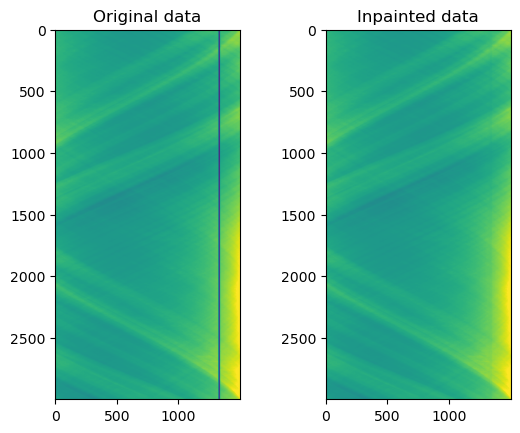

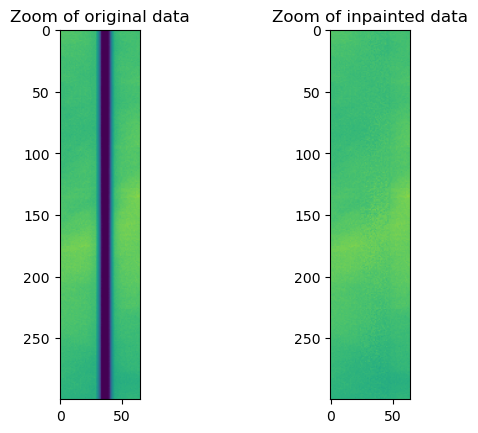

In [21]:
# Inpaint the data with the mask provided 
from httomo.misc.corr import inpainting_filter3d

inpaint_params = pipeline[5]['httomo.misc.corr']['inpainting_filter3d']
pp.pprint(inpaint_params) # print parameters from the YAML template

tomo_inpainted = inpainting_filter3d(data, stripes_mask, 
                                           inpaint_params['number_of_iterations'],
                                           inpaint_params['windowsize_half'],
                                           inpaint_params['method_type'],
                                           ncore=ncore)
plt.figure()
plt.subplot(121)
plt.imshow(data[0:3000,2,1000:2500], vmin= 0.0, vmax = 1.45)
plt.title("Original data")
plt.subplot(122)
plt.imshow(tomo_inpainted[0:3000,2,1000:2500], vmin= 0.0, vmax = 1.45)
plt.title("Inpainted data")
plt.show()

plt.figure()
plt.subplot(121)
plt.imshow(data[0:300,2,2295:2360], vmin= 0.0, vmax = 1.4)
plt.title("Zoom of original data")
plt.subplot(122)
plt.imshow(tomo_inpainted[0:300,2,2295:2360], vmin= 0.0, vmax = 1.4)
plt.title("Zoom of inpainted data")
plt.show()

{'data_in': 'tomo',
 'data_out': 'tomo_destriped',
 'dim': 1,
 'la_size': 61,
 'sm_size': 21,
 'snr': 3}


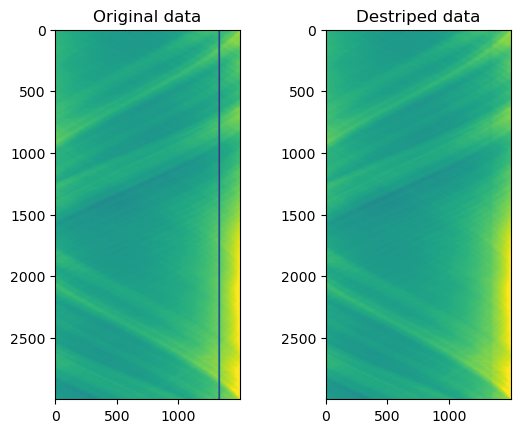

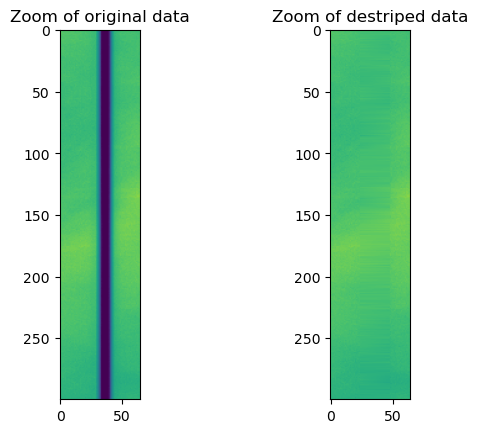

In [27]:
# Let's apply a ring removal method for a comparison
from tomopy.prep.stripe import remove_all_stripe

destripe_params = pipeline[6]['tomopy.prep.stripe']['remove_all_stripe']
pp.pprint(destripe_params) # print parameters from the YAML template

tomo_destriped = remove_all_stripe(data, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[0:3000,2,1000:2500], vmin= 0.0, vmax = 1.45)
plt.title("Original data")
plt.subplot(122)
plt.imshow(tomo_destriped[0:3000,2,1000:2500], vmin= 0.0, vmax = 1.45)
plt.title("Destriped data")
plt.show()

plt.figure()
plt.subplot(121)
plt.imshow(data[0:300,2,2295:2360], vmin= 0.0, vmax = 1.4)
plt.title("Zoom of original data")
plt.subplot(122)
plt.imshow(tomo_destriped[0:300,2,2295:2360], vmin= 0.0, vmax = 1.4)
plt.title("Zoom of destriped data")
plt.show()

Althought the results of inpainting and stripe removal methods look similar, there is an underlying problem of applying the ring removal method to every pixel of the sinogram. Some vertical features can be also distorted by filtering, which can be avoided with more accurate stripe detection methods.

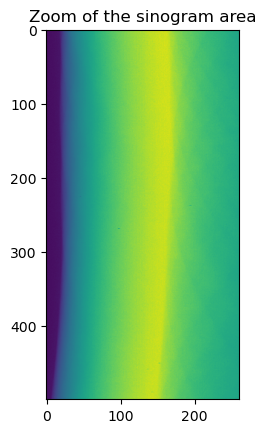

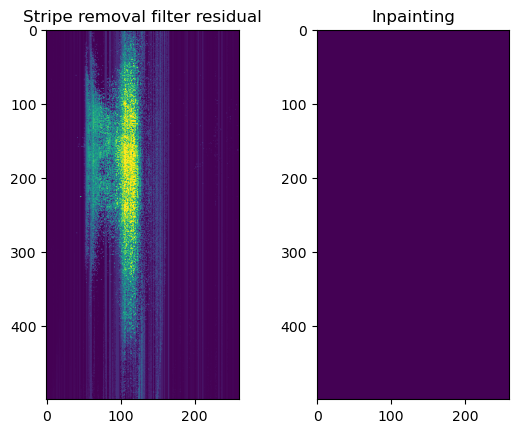

In [48]:
# the differences between ring removal and stripe detected inpaiting
plt.figure()
plt.imshow(data[200:700,2,400:660], vmin= 0.0, vmax = 2.5)
plt.title("Zoom of the sinogram area")
plt.show()

plt.figure()
plt.subplot(121)
plt.imshow(np.abs(data[200:700,2,400:660]-tomo_destriped[200:700,2,400:660]), vmin= 0.0, vmax = 0.1)
plt.title("Stripe removal filter residual")
plt.subplot(122)
plt.imshow(np.abs(data[200:700,2,400:660]-tomo_inpainted[200:700,2,400:660]), vmin= 0.0, vmax = 0.1)
plt.title("Inpainting")
plt.show()

In [50]:
from httomo.recon.rotation import find_center_360

center360_params = pipeline[7]['httomo.recon.rotation']['find_center_360']
pp.pprint(center360_params) # print parameters from the YAML template

(CoR360, overlap, side, overlap_position) = find_center_360(tomo_inpainted[:,2,:])
print(CoR360)

{'data_in': 'tomo_inpainted',
 'data_out': 'tomo',
 'denoise': True,
 'norm': False,
 'side': 'None',
 'use_overlap': False,
 'win_width': 10}
1583.0220031738281


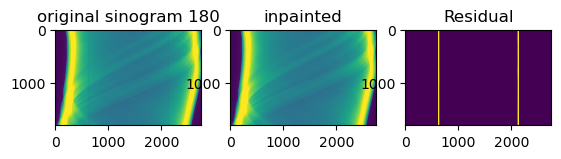

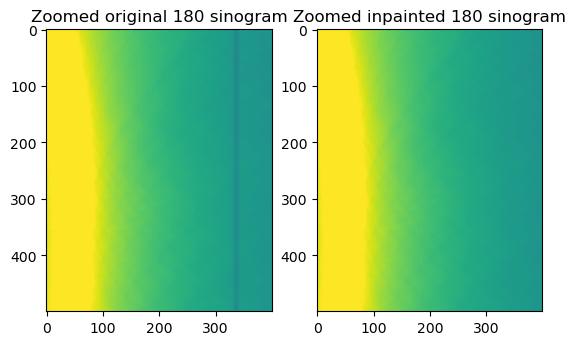

In [51]:
from tomopy.misc.morph import sino_360_to_180

converted_data180 = sino_360_to_180(data, overlap=overlap, rotation='right')
converted_inpainted_data180 = sino_360_to_180(tomo_inpainted, overlap=overlap, rotation='right')

plt.figure()
plt.subplot(131)
plt.imshow(converted_data180[:,2,200:2950], vmin= 0.0, vmax = 2.0)
plt.title("original sinogram 180")
plt.subplot(132)
plt.imshow(converted_inpainted_data180[:,2,200:2950], vmin= 0.0, vmax = 2.0)
plt.title("inpainted")
plt.subplot(133)
plt.imshow(np.abs(converted_data180-converted_inpainted_data180)[:,2,200:2950],  vmin= 0.0, vmax = 0.01)
plt.title("Residual")
plt.show()


plt.figure()
plt.subplot(121)
plt.imshow(converted_data180[0:500,2,500:900], vmin= 0.0, vmax = 2.0)
plt.title("Zoomed original 180 sinogram")
plt.subplot(122)
plt.imshow(converted_inpainted_data180[0:500,2,500:900], vmin= 0.0, vmax = 2.0)
plt.title("Zoomed inpainted 180 sinogram")
plt.show()

In [13]:
converted_data180, dimension = reslice(converted_data180, run_out_dir, dimension, angles_total, detector_y, detector_x, comm)
converted_inpainted_data180, dimension = reslice(converted_inpainted_data180, run_out_dir, dimension, angles_total, detector_y, detector_x, comm)

/media/algol/29B3CEA03D85F0EA/DATA/OUTPUT_SAVU/14-11-2022_13_32_13_output/intermediate.h5
/data
:,:,:


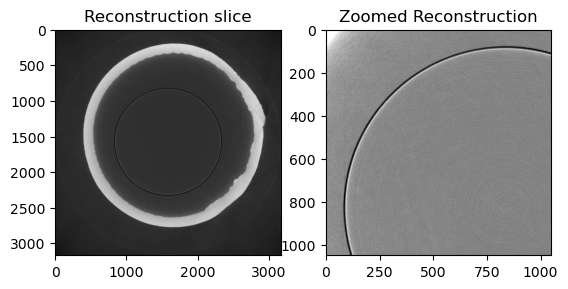

In [14]:
from tomopy.recon.algorithm import recon

recon_original = recon(converted_data180,
              angles,
              center=CoR360,
              algorithm="gridrec",
              sinogram_order=False,
              ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(recon_original[2,:,:], cmap='gray', vmin = -0.001, vmax = 0.004)
plt.title('Reconstruction slice')
plt.subplot(122)
plt.imshow(recon_original[2,750:1800,750:1800], cmap='gray', vmin = -0.001, vmax = 0.0008)
plt.title('Zoomed Reconstruction')
plt.show()

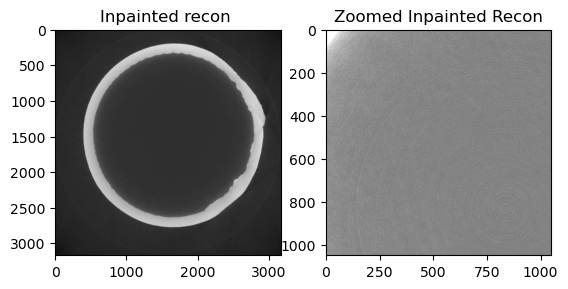

In [15]:
from tomopy.recon.algorithm import recon

recon_inpainted = recon(converted_inpainted_data180,
                angles,
                center=CoR360,
                algorithm="gridrec",
                sinogram_order=False,
                ncore=ncore)
plt.figure()
plt.subplot(121)
plt.imshow(recon_inpainted[2,:,:], cmap='gray', vmin = -0.001, vmax = 0.004)
plt.title('Inpainted recon ')
plt.subplot(122)
plt.imshow(recon_inpainted[2,750:1800,750:1800], cmap='gray', vmin = -0.001, vmax = 0.0008)
plt.title('Zoomed Inpainted Recon')
plt.show()

In [16]:
# save the resulting dataset to images
from httomo.misc.images import save_to_images
from httomo._stats.globals import min_max_mean_std

# get global stats
glob_stats = min_max_mean_std(recon_original, comm)
save_to_images(recon_original, "recon_original", run_out_dir, glob_stats, comm)
glob_stats2 = min_max_mean_std(recon_inpainted, comm)
save_to_images(recon_inpainted, "recon_inpainted", run_out_dir, glob_stats2, comm)